In [1]:
import torch
import tqdm
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.utils.meter import AverageValueMeter
from torch.utils.data import DataLoader, random_split
from utils.image_loading import load_training_images, load_groundtruth_images, load_test_images
from custom_datasets import Sat_Mask_Dataset_UPP_preprocessed
import albumentations as album
from albumentations.pytorch import ToTensorV2


/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR:albumentations.check_version:Error fetching version info
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.12/urllib/request.py", line 1344, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/opt/miniconda3/lib/python3.12/http/client.py", line 1331, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/opt/miniconda3/lib/python3.12/http/client.py", line 1377, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/opt/miniconda3/lib/python3.12/http/client.py", line 1326, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/opt/miniconda3/lib/python3.12/http/client.py", line 1085, in _s

In [2]:
# Check if GPU is available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [3]:
# Preprocessing function
preprocess_input = get_preprocessing_fn('efficientnet-b5', pretrained='imagenet')
preprocess_input =  album.Compose([album.Lambda(image=preprocess_input), ToTensorV2()])

In [19]:
# Load original data
original_data = {}
original_data["images"] = load_training_images()
original_data["masks"] = load_groundtruth_images()

# Load custom data for specified cities
city_names = ["boston", "nyc"]
custom_data = {"images": [], "masks": []}
for name in city_names:
    custom_data["images"].extend(load_training_images(name))
    custom_data["masks"].extend(load_groundtruth_images(name))

In [20]:
# Create datasets
custom_data_set = Sat_Mask_Dataset_UPP_preprocessed(custom_data["images"], custom_data["masks"], min_street_ratio=0.03, max_street_ratio=1.0, upp_preprocess=preprocess_input)
original_data_set = Sat_Mask_Dataset_UPP_preprocessed(original_data["images"], original_data["masks"],  upp_preprocess=preprocess_input)
print("After cleanup, the dataset now contains", len(custom_data_set), "images")

Initialized dataset, checked for min,max street ratio. Discarded %: 0.12071232221823831  num discarded: 1010
Initialized dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
After cleanup, the dataset now contains 7357 images


(400, 400, 3)


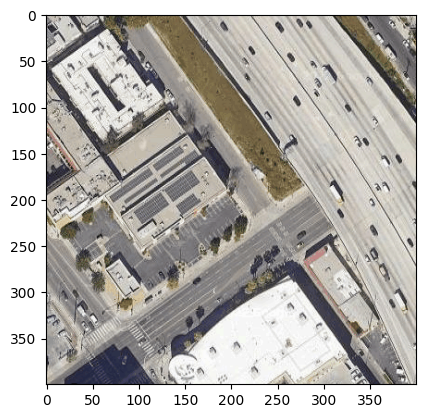

(400, 400, 3)


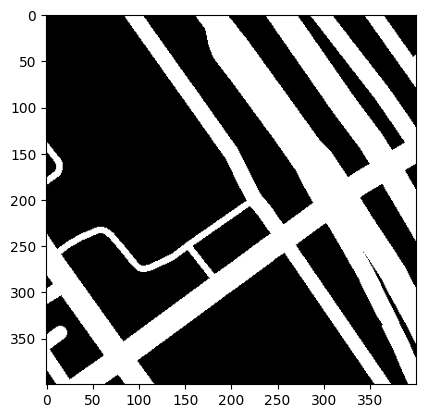

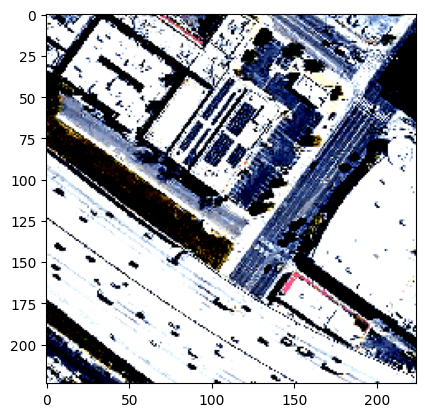

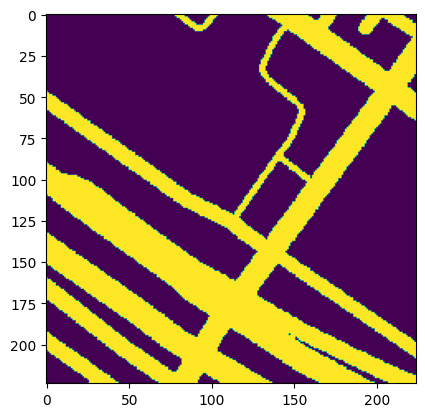

In [6]:
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

print(original_data["images"][0].shape)
plt.imshow(original_data["images"][0])
plt.show()
print(original_data["masks"][0].shape)
plt.imshow(original_data["masks"][0])
plt.show()
item = original_data_set.__getitem__(0)
img_normal = np.swapaxes(item[0], 0, 2)
img_mask = np.swapaxes(item[1], 0, 2)
plt.imshow(img_normal)
plt.show()
plt.imshow(img_mask.squeeze(0))
plt.show()

In [7]:
# Split datasets into training and validation sets
train_size = int(0.8 * len(custom_data_set))
valid_size = len(custom_data_set) - train_size
train_dataset, valid_dataset = random_split(custom_data_set, [train_size, valid_size])

# Create data loaders
batch_size = 30
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### Configure UnetPlusPlus Model

In [5]:
# Define the model
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b5",
    encoder_depth=5,
    encoder_weights="imagenet",
    decoder_use_batchnorm=True,
    decoder_channels=(1024,512,256,64,16),
    decoder_attention_type=None,
    in_channels=3,
    classes=1,
    activation=None,
    aux_params=None
).to(device)

In [9]:
# Define optimizer, scheduler, and loss function
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0005)])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=9, verbose=True, threshold=1e-6, factor=0.5)
loss_function = smp.losses.SoftBCEWithLogitsLoss()

/opt/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [10]:
print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print(sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))

Model loaded
Trainable parameters 54679105
Total parameters 54679105
Percentage of trainable parameters: 
1.0


#### Load The Data

torch.Size([3, 224, 224])
torch.Size([1, 224, 224])


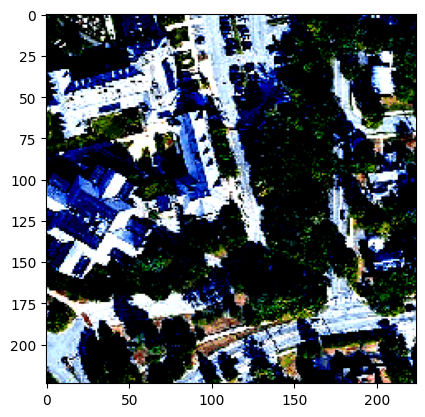

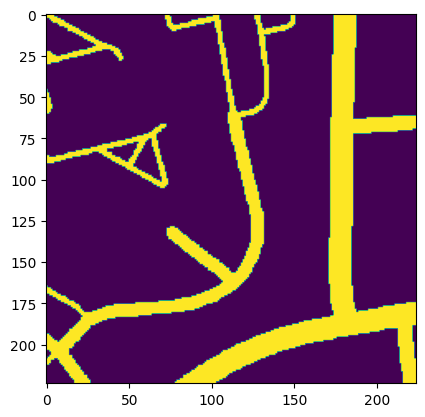

In [11]:
import matplotlib.pyplot as plt
import numpy as np 

item = train_loader.dataset[0]
print(item[0].shape)
print(item[1].shape)
img_normal = np.swapaxes(item[0], 0, 2)
img_mask = np.swapaxes(item[1], 0, 2)
plt.imshow(img_normal)
plt.show()
plt.imshow(img_mask)
plt.show()

In [12]:
# Training loop (unchanged)
# Define metrics and best monitor variable
metrics = ["f1_score", "iou_score", "accuracy"]
check = 0
counter = 0

# Training loop
for epoch in tqdm.tqdm(range(400)):
    model.train()
    training_logs = {}
    loss_meter = AverageValueMeter()
    metrics_meters = {metric: AverageValueMeter() for metric in metrics}

    for _, data in enumerate(tqdm.tqdm(train_loader, leave=False)):
        x, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        y_pred = model.forward(x)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()

        # Update loss logs
        loss_meter.add(loss.item())
        training_logs["SoftBCE"] = loss_meter.mean
        y_int = y.long().cpu().detach()
        tp, fp, fn, tn = smp.metrics.get_stats(output=y_pred.cpu().detach(), target=y_int, mode='binary', threshold=0.5)
        # Update metrics logs
        for metric in metrics:
            metric_fnc = getattr(smp.metrics, metric)
            metric_value = metric_fnc(tp, fp, fn, tn, reduction="micro").cpu().numpy()
            metrics_meters[metric].add(metric_value)
        training_logs.update({k: v.mean for k, v in metrics_meters.items()})

    # Print training logs for the current epoch
    print(f"Epoch {epoch + 1} - Training Loss: {training_logs['SoftBCE']:.4f}, " +
          ", ".join([f"{metric}: {training_logs[metric]:.4f}" for metric in metrics]))

    # Validation loop
    model.eval()
    valid_logs = {}
    loss_meter = AverageValueMeter()
    metrics_meters = {metric: AverageValueMeter() for metric in metrics}

    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model.forward(x)
            loss = loss_function(y_pred, y)

        # Update loss logs
        loss_meter.add(loss.item())
        valid_logs["SoftBCE"] = loss_meter.mean
        y_int = y.long()
        tp, fp, fn, tn = smp.metrics.get_stats(output=y_pred, target=y_int, mode='binary', threshold=0.5)
        # Update metrics logs
        for metric in metrics:
            metric_fnc = getattr(smp.metrics, metric)
            metric_value = metric_fnc(tp, fp, fn, tn, reduction="micro").cpu().numpy()
            metrics_meters[metric].add(metric_value)
        valid_logs.update({k: v.mean for k, v in metrics_meters.items()})

    # Print validation logs for the current epoch
    print(f"Epoch {epoch + 1} - Validation Loss: {valid_logs['SoftBCE']:.4f}, " +
          ", ".join([f"{metric}: {valid_logs[metric]:.4f}" for metric in metrics]))

    scheduler.step(valid_logs["iou_score"])

    if check < valid_logs["iou_score"]:
        check = valid_logs["iou_score"]
        counter = 0
        torch.save(model.state_dict(), "best_model_pre.pth")
        print(f"New best model found at epoch {epoch + 1} with IoU score: {check:.4f}")
    else:
        counter += 1
        print(counter)
    if counter == 6:
        break

# Final performance
print(f"Best Validation IoU Score: {check:.4f}")

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1 - Training Loss: 0.2224, f1_score: 0.6995, iou_score: 0.5418, accuracy: 0.9217
Epoch 1 - Validation Loss: 0.1618, f1_score: 0.7680, iou_score: 0.6238, accuracy: 0.9383


  0%|          | 1/400 [07:12<47:53:08, 432.05s/it]

New best model found at epoch 1 with IoU score: 0.6238


Epoch 2 - Training Loss: 0.1545, f1_score: 0.7688, iou_score: 0.6248, accuracy: 0.9384
Epoch 2 - Validation Loss: 0.1477, f1_score: 0.7771, iou_score: 0.6362, accuracy: 0.9409


  0%|          | 2/400 [23:32<83:25:01, 754.53s/it]

New best model found at epoch 2 with IoU score: 0.6362


Epoch 3 - Training Loss: 0.1439, f1_score: 0.7857, iou_score: 0.6476, accuracy: 0.9422
Epoch 3 - Validation Loss: 0.1391, f1_score: 0.7947, iou_score: 0.6601, accuracy: 0.9450


  1%|          | 3/400 [39:37<93:49:48, 850.85s/it]

New best model found at epoch 3 with IoU score: 0.6601


Epoch 4 - Training Loss: 0.1351, f1_score: 0.7984, iou_score: 0.6649, accuracy: 0.9453


  1%|          | 4/400 [53:32<92:54:12, 844.58s/it]

Epoch 4 - Validation Loss: 0.1581, f1_score: 0.7044, iou_score: 0.5441, accuracy: 0.9300
1


Epoch 5 - Training Loss: 0.1307, f1_score: 0.8048, iou_score: 0.6738, accuracy: 0.9469


  1%|▏         | 5/400 [1:05:46<88:16:32, 804.54s/it]

Epoch 5 - Validation Loss: 0.1374, f1_score: 0.7711, iou_score: 0.6283, accuracy: 0.9419
2


Epoch 6 - Training Loss: 0.1252, f1_score: 0.8133, iou_score: 0.6857, accuracy: 0.9489
Epoch 6 - Validation Loss: 0.1332, f1_score: 0.7987, iou_score: 0.6654, accuracy: 0.9466


  2%|▏         | 6/400 [1:18:45<87:06:44, 795.95s/it]

New best model found at epoch 6 with IoU score: 0.6654


Epoch 7 - Training Loss: 0.1214, f1_score: 0.8199, iou_score: 0.6951, accuracy: 0.9504
Epoch 7 - Validation Loss: 0.1306, f1_score: 0.8127, iou_score: 0.6851, accuracy: 0.9492


  2%|▏         | 7/400 [1:34:29<92:09:37, 844.22s/it]

New best model found at epoch 7 with IoU score: 0.6851


Epoch 8 - Training Loss: 0.1183, f1_score: 0.8240, iou_score: 0.7011, accuracy: 0.9513


  2%|▏         | 8/400 [1:52:15<99:38:18, 915.05s/it]

Epoch 8 - Validation Loss: 0.1294, f1_score: 0.8079, iou_score: 0.6783, accuracy: 0.9483
1


Epoch 9 - Training Loss: 0.1145, f1_score: 0.8294, iou_score: 0.7088, accuracy: 0.9528
Epoch 9 - Validation Loss: 0.1281, f1_score: 0.8176, iou_score: 0.6920, accuracy: 0.9500


  2%|▏         | 9/400 [2:09:49<104:06:02, 958.47s/it]

New best model found at epoch 9 with IoU score: 0.6920


Epoch 10 - Training Loss: 0.1110, f1_score: 0.8348, iou_score: 0.7167, accuracy: 0.9541
Epoch 10 - Validation Loss: 0.1327, f1_score: 0.8228, iou_score: 0.6995, accuracy: 0.9505


  2%|▎         | 10/400 [2:27:02<106:19:51, 981.52s/it]

New best model found at epoch 10 with IoU score: 0.6995


Epoch 11 - Training Loss: 0.1078, f1_score: 0.8395, iou_score: 0.7237, accuracy: 0.9553


  3%|▎         | 11/400 [2:44:17<107:49:04, 997.80s/it]

Epoch 11 - Validation Loss: 0.1290, f1_score: 0.8179, iou_score: 0.6925, accuracy: 0.9503
1


Epoch 12 - Training Loss: 0.1058, f1_score: 0.8427, iou_score: 0.7285, accuracy: 0.9560
Epoch 12 - Validation Loss: 0.1285, f1_score: 0.8274, iou_score: 0.7063, accuracy: 0.9515


  3%|▎         | 12/400 [3:01:26<108:33:02, 1007.17s/it]

New best model found at epoch 12 with IoU score: 0.7063


Epoch 13 - Training Loss: 0.1028, f1_score: 0.8469, iou_score: 0.7348, accuracy: 0.9571


  3%|▎         | 13/400 [3:18:32<108:53:32, 1012.95s/it]

Epoch 13 - Validation Loss: 0.1281, f1_score: 0.8246, iou_score: 0.7021, accuracy: 0.9515
1


Epoch 14 - Training Loss: 0.1006, f1_score: 0.8498, iou_score: 0.7392, accuracy: 0.9579
Epoch 14 - Validation Loss: 0.1275, f1_score: 0.8280, iou_score: 0.7070, accuracy: 0.9520


  4%|▎         | 14/400 [3:35:37<109:00:23, 1016.64s/it]

New best model found at epoch 14 with IoU score: 0.7070


Epoch 15 - Training Loss: 0.0983, f1_score: 0.8535, iou_score: 0.7447, accuracy: 0.9588


  4%|▍         | 15/400 [3:52:48<109:10:31, 1020.86s/it]

Epoch 15 - Validation Loss: 0.1270, f1_score: 0.8236, iou_score: 0.7007, accuracy: 0.9516
1


Epoch 16 - Training Loss: 0.0960, f1_score: 0.8564, iou_score: 0.7492, accuracy: 0.9596


  4%|▍         | 16/400 [4:09:53<109:02:08, 1022.21s/it]

Epoch 16 - Validation Loss: 0.1295, f1_score: 0.8210, iou_score: 0.6968, accuracy: 0.9510
2


Epoch 17 - Training Loss: 0.0953, f1_score: 0.8576, iou_score: 0.7511, accuracy: 0.9599


  4%|▍         | 17/400 [4:27:13<109:18:31, 1027.44s/it]

Epoch 17 - Validation Loss: 0.1310, f1_score: 0.8168, iou_score: 0.6910, accuracy: 0.9505
3


Epoch 18 - Training Loss: 0.0956, f1_score: 0.8571, iou_score: 0.7502, accuracy: 0.9598


  4%|▍         | 18/400 [4:42:50<106:08:54, 1000.35s/it]

Epoch 18 - Validation Loss: 0.1268, f1_score: 0.8252, iou_score: 0.7029, accuracy: 0.9519
4


Epoch 19 - Training Loss: 0.0912, f1_score: 0.8634, iou_score: 0.7599, accuracy: 0.9614
Epoch 19 - Validation Loss: 0.1281, f1_score: 0.8300, iou_score: 0.7099, accuracy: 0.9527


  5%|▍         | 19/400 [4:58:52<104:38:41, 988.77s/it] 

New best model found at epoch 19 with IoU score: 0.7099


Epoch 20 - Training Loss: 0.0896, f1_score: 0.8662, iou_score: 0.7642, accuracy: 0.9621
Epoch 20 - Validation Loss: 0.1301, f1_score: 0.8327, iou_score: 0.7139, accuracy: 0.9531


  5%|▌         | 20/400 [5:14:43<103:10:53, 977.51s/it]

New best model found at epoch 20 with IoU score: 0.7139


Epoch 21 - Training Loss: 0.0873, f1_score: 0.8692, iou_score: 0.7690, accuracy: 0.9629


  5%|▌         | 21/400 [5:27:55<97:02:53, 921.83s/it] 

Epoch 21 - Validation Loss: 0.1310, f1_score: 0.8288, iou_score: 0.7082, accuracy: 0.9525
1


Epoch 22 - Training Loss: 0.0865, f1_score: 0.8709, iou_score: 0.7718, accuracy: 0.9633


  6%|▌         | 22/400 [5:34:18<79:47:37, 759.94s/it]

Epoch 22 - Validation Loss: 0.1422, f1_score: 0.8271, iou_score: 0.7057, accuracy: 0.9521
2


Epoch 23 - Training Loss: 0.0873, f1_score: 0.8693, iou_score: 0.7691, accuracy: 0.9629


  6%|▌         | 23/400 [5:40:35<67:33:02, 645.05s/it]

Epoch 23 - Validation Loss: 0.1306, f1_score: 0.8289, iou_score: 0.7084, accuracy: 0.9525
3


Epoch 24 - Training Loss: 0.0839, f1_score: 0.8742, iou_score: 0.7767, accuracy: 0.9642


  6%|▌         | 24/400 [5:46:52<58:59:34, 564.83s/it]

Epoch 24 - Validation Loss: 0.1339, f1_score: 0.8200, iou_score: 0.6955, accuracy: 0.9514
4


Epoch 25 - Training Loss: 0.0813, f1_score: 0.8779, iou_score: 0.7826, accuracy: 0.9652


  6%|▋         | 25/400 [5:53:10<52:58:36, 508.58s/it]

Epoch 25 - Validation Loss: 0.1330, f1_score: 0.8322, iou_score: 0.7130, accuracy: 0.9532
5


Epoch 26 - Training Loss: 0.0801, f1_score: 0.8799, iou_score: 0.7858, accuracy: 0.9657


  6%|▋         | 25/400 [5:59:27<89:51:51, 862.70s/it]

Epoch 26 - Validation Loss: 0.1377, f1_score: 0.8285, iou_score: 0.7077, accuracy: 0.9524
6
Best Validation IoU Score: 0.7139


In [13]:
# Load the saved model for further training on the original dataset
model.load_state_dict(torch.load("best_model_pre.pth"))

<All keys matched successfully>

In [14]:
# Split the original dataset into training and validation sets
train_size = int(0.8 * len(original_data_set))
valid_size = len(original_data_set) - train_size
train_dataset, valid_dataset = random_split(original_data_set, [train_size, valid_size])

# Create new data loaders for the original dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [15]:
counter = 0 
check = 0

# Continue training loop with the original dataset
for epoch in tqdm.tqdm(range(100)):
    model.train()
    training_logs = {}
    loss_meter = AverageValueMeter()
    metrics_meters = {metric: AverageValueMeter() for metric in metrics}

    for x, y in tqdm.tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model.forward(x)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()

        # Update loss logs
        loss_meter.add(loss.item())
        training_logs["SoftBCE"] = loss_meter.mean
        y_int = y.long().cpu().detach()
        tp, fp, fn, tn = smp.metrics.get_stats(output=y_pred.cpu().detach(), target=y_int, mode='binary', threshold=0.5)
        # Update metrics logs
        for metric in metrics:
            metric_fnc = getattr(smp.metrics, metric)
            metric_value = metric_fnc(tp, fp, fn, tn, reduction="micro").cpu().numpy()
            metrics_meters[metric].add(metric_value)
        training_logs.update({k: v.mean for k, v in metrics_meters.items()})

    # Print training logs for the current epoch
    print(f"Epoch {epoch + 1} - Training Loss: {training_logs['SoftBCE']:.4f}, " +
          ", ".join([f"{metric}: {training_logs[metric]:.4f}" for metric in metrics]))

    # Validation loop
    model.eval()
    valid_logs = {}
    loss_meter = AverageValueMeter()
    metrics_meters = {metric: AverageValueMeter() for metric in metrics}

    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model.forward(x)
            loss = loss_function(y_pred, y)

        # Update loss logs
        loss_meter.add(loss.item())
        valid_logs["SoftBCE"] = loss_meter.mean
        y_int = y.long()
        tp, fp, fn, tn = smp.metrics.get_stats(output=y_pred, target=y_int, mode='binary', threshold=0.5)
        # Update metrics logs
        for metric in metrics:
            metric_fnc = getattr(smp.metrics, metric)
            metric_value = metric_fnc(tp, fp, fn, tn, reduction="micro").cpu().numpy()
            metrics_meters[metric].add(metric_value)
        valid_logs.update({k: v.mean for k, v in metrics_meters.items()})

    # Print validation logs for the current epoch
    print(f"Epoch {epoch + 1} - Validation Loss: {valid_logs['SoftBCE']:.4f}, " +
          ", ".join([f"{metric}: {valid_logs[metric]:.4f}" for metric in metrics]))

    scheduler.step(valid_logs["iou_score"])

    if check < valid_logs["iou_score"]:
        check = valid_logs["iou_score"]
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print(f"New best model found at epoch {epoch + 1} with IoU score: {check:.4f}")
    else:
        counter += 1
    if counter == 10:
        break

print(f"Final Validation IoU Score: {check:.4f}")

100%|██████████| 4/4 [00:12<00:00,  3.14s/it]


Epoch 1 - Training Loss: 0.2229, f1_score: 0.7606, iou_score: 0.6145, accuracy: 0.9252
Epoch 1 - Validation Loss: 0.2483, f1_score: 0.7854, iou_score: 0.6466, accuracy: 0.9254


  1%|          | 1/100 [00:15<25:49, 15.65s/it]

New best model found at epoch 1 with IoU score: 0.6466


100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


Epoch 2 - Training Loss: 0.1723, f1_score: 0.7717, iou_score: 0.6284, accuracy: 0.9308


  2%|▏         | 2/100 [00:24<18:50, 11.53s/it]

Epoch 2 - Validation Loss: 0.3992, f1_score: 0.7430, iou_score: 0.5911, accuracy: 0.9161


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Epoch 3 - Training Loss: 0.1623, f1_score: 0.7582, iou_score: 0.6108, accuracy: 0.9291


  3%|▎         | 3/100 [00:33<16:56, 10.48s/it]

Epoch 3 - Validation Loss: 0.3263, f1_score: 0.7743, iou_score: 0.6317, accuracy: 0.9230


100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


Epoch 4 - Training Loss: 0.1477, f1_score: 0.7980, iou_score: 0.6642, accuracy: 0.9380


  4%|▍         | 4/100 [00:46<18:02, 11.27s/it]

Epoch 4 - Validation Loss: 0.2347, f1_score: 0.7766, iou_score: 0.6347, accuracy: 0.9233


100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Epoch 5 - Training Loss: 0.1448, f1_score: 0.8160, iou_score: 0.6892, accuracy: 0.9412


  5%|▌         | 5/100 [00:56<17:15, 10.90s/it]

Epoch 5 - Validation Loss: 0.2122, f1_score: 0.7759, iou_score: 0.6338, accuracy: 0.9236


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


Epoch 6 - Training Loss: 0.1370, f1_score: 0.8204, iou_score: 0.6955, accuracy: 0.9428


  6%|▌         | 6/100 [01:05<16:18, 10.41s/it]

Epoch 6 - Validation Loss: 0.1960, f1_score: 0.7850, iou_score: 0.6461, accuracy: 0.9266


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Epoch 7 - Training Loss: 0.1342, f1_score: 0.8191, iou_score: 0.6938, accuracy: 0.9432
Epoch 7 - Validation Loss: 0.1910, f1_score: 0.7867, iou_score: 0.6484, accuracy: 0.9267


  7%|▋         | 7/100 [01:16<16:14, 10.48s/it]

New best model found at epoch 7 with IoU score: 0.6484


100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


Epoch 8 - Training Loss: 0.1280, f1_score: 0.8292, iou_score: 0.7082, accuracy: 0.9457
Epoch 8 - Validation Loss: 0.1878, f1_score: 0.7919, iou_score: 0.6555, accuracy: 0.9279


  8%|▊         | 8/100 [01:26<15:42, 10.25s/it]

New best model found at epoch 8 with IoU score: 0.6555


100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


Epoch 9 - Training Loss: 0.1239, f1_score: 0.8349, iou_score: 0.7168, accuracy: 0.9472
Epoch 9 - Validation Loss: 0.1827, f1_score: 0.8029, iou_score: 0.6707, accuracy: 0.9310


  9%|▉         | 9/100 [01:38<16:39, 10.99s/it]

New best model found at epoch 9 with IoU score: 0.6707


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


Epoch 10 - Training Loss: 0.1241, f1_score: 0.8404, iou_score: 0.7249, accuracy: 0.9483


 10%|█         | 10/100 [01:49<16:20, 10.90s/it]

Epoch 10 - Validation Loss: 0.1885, f1_score: 0.7979, iou_score: 0.6638, accuracy: 0.9290


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Epoch 11 - Training Loss: 0.1174, f1_score: 0.8508, iou_score: 0.7404, accuracy: 0.9515
Epoch 11 - Validation Loss: 0.1836, f1_score: 0.8042, iou_score: 0.6725, accuracy: 0.9309


 11%|█         | 11/100 [01:59<15:40, 10.57s/it]

New best model found at epoch 11 with IoU score: 0.6725


100%|██████████| 4/4 [00:11<00:00,  2.83s/it]


Epoch 12 - Training Loss: 0.1131, f1_score: 0.8501, iou_score: 0.7393, accuracy: 0.9516


 12%|█▏        | 12/100 [02:11<16:14, 11.08s/it]

Epoch 12 - Validation Loss: 0.1844, f1_score: 0.8019, iou_score: 0.6693, accuracy: 0.9302


100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


Epoch 13 - Training Loss: 0.1122, f1_score: 0.8528, iou_score: 0.7435, accuracy: 0.9522


 13%|█▎        | 13/100 [02:20<15:11, 10.47s/it]

Epoch 13 - Validation Loss: 0.1865, f1_score: 0.8030, iou_score: 0.6709, accuracy: 0.9310


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


Epoch 14 - Training Loss: 0.1074, f1_score: 0.8601, iou_score: 0.7547, accuracy: 0.9543
Epoch 14 - Validation Loss: 0.1861, f1_score: 0.8065, iou_score: 0.6757, accuracy: 0.9312


 14%|█▍        | 14/100 [02:31<15:18, 10.68s/it]

New best model found at epoch 14 with IoU score: 0.6757


100%|██████████| 4/4 [00:12<00:00,  3.07s/it]


Epoch 15 - Training Loss: 0.1072, f1_score: 0.8641, iou_score: 0.7607, accuracy: 0.9552


 15%|█▌        | 15/100 [02:45<16:18, 11.52s/it]

Epoch 15 - Validation Loss: 0.1898, f1_score: 0.8041, iou_score: 0.6724, accuracy: 0.9303


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Epoch 16 - Training Loss: 0.1034, f1_score: 0.8677, iou_score: 0.7663, accuracy: 0.9566


 16%|█▌        | 16/100 [02:54<15:09, 10.83s/it]

Epoch 16 - Validation Loss: 0.1907, f1_score: 0.8043, iou_score: 0.6727, accuracy: 0.9308


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Epoch 17 - Training Loss: 0.1058, f1_score: 0.8625, iou_score: 0.7583, accuracy: 0.9552


 17%|█▋        | 17/100 [03:03<14:27, 10.46s/it]

Epoch 17 - Validation Loss: 0.1950, f1_score: 0.8034, iou_score: 0.6715, accuracy: 0.9299


100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 18 - Training Loss: 0.1015, f1_score: 0.8654, iou_score: 0.7627, accuracy: 0.9563
Epoch 18 - Validation Loss: 0.1880, f1_score: 0.8093, iou_score: 0.6797, accuracy: 0.9319


 18%|█▊        | 18/100 [03:12<13:41, 10.02s/it]

New best model found at epoch 18 with IoU score: 0.6797


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Epoch 19 - Training Loss: 0.1004, f1_score: 0.8696, iou_score: 0.7694, accuracy: 0.9575
Epoch 19 - Validation Loss: 0.1860, f1_score: 0.8151, iou_score: 0.6880, accuracy: 0.9340


 19%|█▉        | 19/100 [03:22<13:22,  9.90s/it]

New best model found at epoch 19 with IoU score: 0.6880


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Epoch 20 - Training Loss: 0.0996, f1_score: 0.8713, iou_score: 0.7720, accuracy: 0.9577


 20%|██        | 20/100 [03:32<13:00,  9.76s/it]

Epoch 20 - Validation Loss: 0.1915, f1_score: 0.8070, iou_score: 0.6765, accuracy: 0.9315


100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 21 - Training Loss: 0.1003, f1_score: 0.8695, iou_score: 0.7692, accuracy: 0.9572


 21%|██        | 21/100 [03:40<12:21,  9.39s/it]

Epoch 21 - Validation Loss: 0.1887, f1_score: 0.8094, iou_score: 0.6798, accuracy: 0.9324


100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 22 - Training Loss: 0.0970, f1_score: 0.8746, iou_score: 0.7771, accuracy: 0.9588


 22%|██▏       | 22/100 [03:48<11:46,  9.06s/it]

Epoch 22 - Validation Loss: 0.1921, f1_score: 0.8106, iou_score: 0.6815, accuracy: 0.9326


100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 23 - Training Loss: 0.0973, f1_score: 0.8744, iou_score: 0.7769, accuracy: 0.9585


 23%|██▎       | 23/100 [03:57<11:20,  8.84s/it]

Epoch 23 - Validation Loss: 0.1934, f1_score: 0.8086, iou_score: 0.6787, accuracy: 0.9322


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


Epoch 24 - Training Loss: 0.0936, f1_score: 0.8791, iou_score: 0.7842, accuracy: 0.9601


 24%|██▍       | 24/100 [04:06<11:19,  8.94s/it]

Epoch 24 - Validation Loss: 0.1920, f1_score: 0.8065, iou_score: 0.6757, accuracy: 0.9312


100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


Epoch 25 - Training Loss: 0.0947, f1_score: 0.8773, iou_score: 0.7815, accuracy: 0.9597


 25%|██▌       | 25/100 [04:14<11:01,  8.82s/it]

Epoch 25 - Validation Loss: 0.1966, f1_score: 0.8094, iou_score: 0.6798, accuracy: 0.9317


100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 26 - Training Loss: 0.0950, f1_score: 0.8775, iou_score: 0.7819, accuracy: 0.9597


 26%|██▌       | 26/100 [04:23<10:39,  8.64s/it]

Epoch 26 - Validation Loss: 0.1943, f1_score: 0.8056, iou_score: 0.6744, accuracy: 0.9303


100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


Epoch 27 - Training Loss: 0.0974, f1_score: 0.8725, iou_score: 0.7742, accuracy: 0.9583


 27%|██▋       | 27/100 [04:31<10:30,  8.64s/it]

Epoch 27 - Validation Loss: 0.1909, f1_score: 0.8110, iou_score: 0.6821, accuracy: 0.9321


100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


Epoch 28 - Training Loss: 0.0917, f1_score: 0.8818, iou_score: 0.7887, accuracy: 0.9611


 28%|██▊       | 28/100 [04:40<10:22,  8.64s/it]

Epoch 28 - Validation Loss: 0.1918, f1_score: 0.8107, iou_score: 0.6816, accuracy: 0.9319


100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 29 - Training Loss: 0.0928, f1_score: 0.8804, iou_score: 0.7867, accuracy: 0.9606


 28%|██▊       | 28/100 [04:48<12:22, 10.31s/it]

Epoch 29 - Validation Loss: 0.1882, f1_score: 0.8147, iou_score: 0.6874, accuracy: 0.9332
Final Validation IoU Score: 0.6880


In [6]:
# Load the saved model for further training on the original dataset
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [7]:
from custom_datasets import Sat_Only_Image_UPP_preprocessed
kaggle_submission_images = load_test_images()
submission_data_set = Sat_Only_Image_UPP_preprocessed(kaggle_submission_images, upp_preprocess=preprocess_input)

In [8]:
submission_dataloader = DataLoader(submission_data_set, batch_size=30, shuffle=False, drop_last=False,num_workers=4,persistent_workers=True)

In [25]:
model.eval()
pair = original_data_set[0]
pred = None
with torch.no_grad():
    image = pair[0].unsqueeze(0).to(device)
    pred = model(image).cpu()

In [27]:
print(pred.squeeze(0).shape)


torch.Size([1, 224, 224])


In [13]:
import torch.nn as nn

from tqdm import tqdm

model.eval()
predictions = []

with torch.no_grad():
    for image in tqdm(submission_dataloader):
        image = image.to(device)
        pred = model(image)
        predictions.append(pred.cpu())

100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


In [29]:
print(pair[0].shape)

torch.Size([3, 224, 224])


(400, 400, 3)
torch.Size([1, 224, 224])


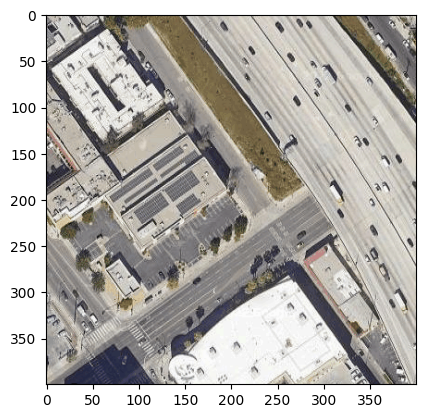

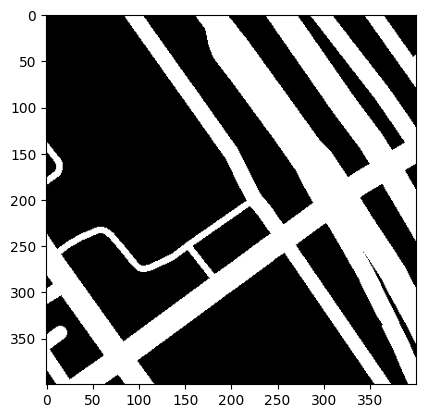

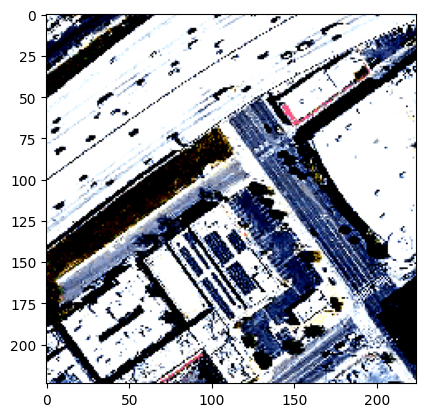

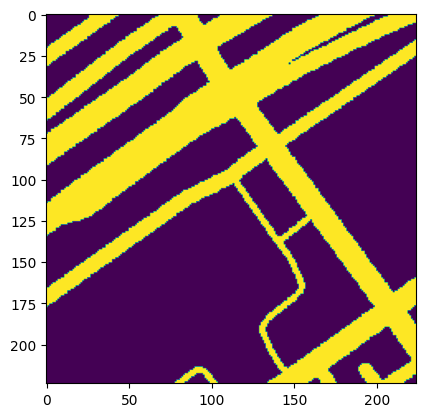

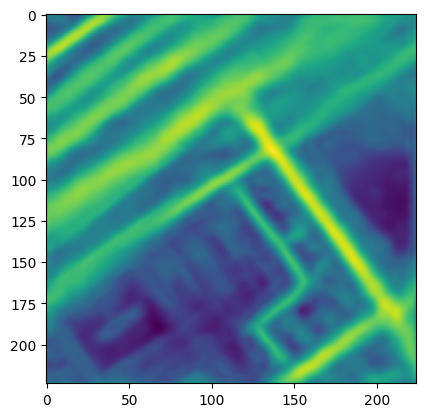

In [35]:
import matplotlib.pyplot as plt
import numpy as np 

# item = train_loader.dataset[0]
print(kaggle_submission_images[0].shape)
print(predictions[0][0].shape)
kaggle_submission_images
img_normal = np.swapaxes(pair[0], 0, 2)
img_mask = np.swapaxes(pair[1], 0, 2)
img_pred = np.swapaxes(pred.squeeze(0), 0, 2)
plt.imshow(original_data["images"][0])
plt.show()
plt.imshow(original_data["masks"][0])
plt.show()
plt.imshow(img_normal)
plt.show()
plt.imshow(img_mask)
plt.show()
plt.imshow(img_pred)
plt.show()

In [31]:
print(img_mask)

tensor([[[0.],
         [0.],
         [0.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]])
